In [1]:
#text clustering
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [13]:
#from google.colab import drive
#drive.mount('/content/drive')


In [12]:
df = pd.read_csv('/content/drive/My Drive/doublecut.csv')
df.head()

,id,topic,heading,summary,date,sub,content,tags
0,5ef0d321d83b3587cb500efc,"[""football""]","[""VAR not being used correctly: Barcelona coac...","[""Barcelona had a goal ruled out by VAR for of...","[""Updated: Jun 22, 2020 20:03 IST""]","[""Reuters""]","[""The Video Assistant Referee (VAR) system is ...","[""Quique Setien"",""Barcelona""]"
1,5ef0d324d83b3587cb500efd,"[""football""]","[""Mourinho hits back at Mersonâ€™s criticism o...","[""Merson, a pundit with Sky Sports, said 26-ye...","[""Updated: Jun 22, 2020 20:30 IST""]","[""Reuters""]","[""Jose Mourinho launched an impassioned defenc...","[""Jose Mourinho"",""Harry Kane"",""Manchester unit..."
2,5efff14f86936ae10d2be3c8,"[""football""]","[""Morata double leads Atletico to 3-0 win over...","[""Morata earned a penalty when he was pulled d...","[""Updated: Jul 04, 2020 07:12 IST""]","[""Associated Press""]","[""Alvaro Morata scored twice to lead Atletico ...","[""Alvaro Morata"",""Mallorca"",""Diego Simeone"",""R..."
3,5efff10a86936ae10d2be3aa,"[""cricket""]","[""Sourav Ganguly made Sehwag open, brought in ...","[""Former India opener Wasim Jaffer, who made h...","[""Updated: Jul 04, 2020 08:03 IST""]","[""hindustantimes.com""]","[""Despite not being able to lead India to an I...","[""Sourav Ganguly"",""Wasim Jaffer"",""India"",""Zahe..."
4,5ef0d2e5d83b3587cb500edf,"[""cricket""]","[""Jasprit Bumrah is â€˜a different beastâ€™ wh...","[""The man in charge of the team currently is h...","[""Updated: Jun 22, 2020 20:57 IST""]","[""hindustantimes.com""]","[""Mumbai Indians are the most successful team ...","[""Mumbai Indians"",""Jasprit Bumrah"",""Mahela Jay..."


In [14]:
df.shape

(7, 8)

In [15]:
import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
# data preprocessing
stemmer = SnowballStemmer(language='english',ignore_stopwords=True)
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [17]:
# preview after preprocessing
doc_sample = df.content[0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['["The', 'Video', 'Assistant', 'Referee', '(VAR)', 'system', 'is', 'not', 'being', 'used', 'correctly', 'in', 'La', 'Liga,', 'Barcelona', 'manager', 'Quique', 'Setien', 'said', 'on', 'Monday', 'following', 'Real', 'Madridâ€™s', 'controversial', 'win', 'at', 'Real', 'Sociedad.","Madrid', 'beat', 'Sociedad', '2-1', 'to', 'climb', 'above', 'Barcelona', 'at', 'the', 'top', 'of', 'La', 'Liga', 'but', 'the', 'home', 'side', 'were', 'aggrieved', 'because', 'they', 'had', 'a', 'goal', 'ruled', 'out', 'by', 'VAR', 'for', 'offside', 'and', 'Karim', 'Benzemaâ€™s', 'winner', 'stood', 'after', 'he', 'appeared', 'to', 'control', 'the', 'ball', 'with', 'his', 'arm.","â€œThere', 'are', 'things', 'that', 'we', 'cannot', 'control', 'and', 'that', 'do', 'not', 'depend', 'on', 'us.', 'Everybody', 'saw', 'what', 'happened', 'in', 'Anoeta', 'and', 'everyone', 'will', 'draw', 'their', 'own', 'conclusions,â€\x9d', 'Setien', 'told', 'reporters', 'ahead', 'of', 'Tuesdayâ€™s', 'match', 'agai

In [18]:
# Preprocess the headline text, saving the results as ‘processed_docs’
processed_docs = df['content'].map(preprocess)
#processed_docs.head(5)
df['processed_content'] = processed_docs
#df.head()
df['processed_content'] = df['processed_content'].apply(lambda x: ' '.join(x))

df.head()

,id,topic,heading,summary,date,sub,content,tags,processed_content
0,5ef0d321d83b3587cb500efc,"[""football""]","[""VAR not being used correctly: Barcelona coac...","[""Barcelona had a goal ruled out by VAR for of...","[""Updated: Jun 22, 2020 20:03 IST""]","[""Reuters""]","[""The Video Assistant Referee (VAR) system is ...","[""Quique Setien"",""Barcelona""]",video assist refere correct liga barcelona man...
1,5ef0d324d83b3587cb500efd,"[""football""]","[""Mourinho hits back at Mersonâ€™s criticism o...","[""Merson, a pundit with Sky Sports, said 26-ye...","[""Updated: Jun 22, 2020 20:30 IST""]","[""Reuters""]","[""Jose Mourinho launched an impassioned defenc...","[""Jose Mourinho"",""Harry Kane"",""Manchester unit...",jose mourinho launch impass defenc harri kaneâ...
2,5efff14f86936ae10d2be3c8,"[""football""]","[""Morata double leads Atletico to 3-0 win over...","[""Morata earned a penalty when he was pulled d...","[""Updated: Jul 04, 2020 07:12 IST""]","[""Associated Press""]","[""Alvaro Morata scored twice to lead Atletico ...","[""Alvaro Morata"",""Mallorca"",""Diego Simeone"",""R...",alvaro morata score twice lead atletico madrid...
3,5efff10a86936ae10d2be3aa,"[""cricket""]","[""Sourav Ganguly made Sehwag open, brought in ...","[""Former India opener Wasim Jaffer, who made h...","[""Updated: Jul 04, 2020 08:03 IST""]","[""hindustantimes.com""]","[""Despite not being able to lead India to an I...","[""Sourav Ganguly"",""Wasim Jaffer"",""India"",""Zahe...",despit abl lead india trophi sole india joint ...
4,5ef0d2e5d83b3587cb500edf,"[""cricket""]","[""Jasprit Bumrah is â€˜a different beastâ€™ wh...","[""The man in charge of the team currently is h...","[""Updated: Jun 22, 2020 20:57 IST""]","[""hindustantimes.com""]","[""Mumbai Indians are the most successful team ...","[""Mumbai Indians"",""Jasprit Bumrah"",""Mahela Jay...",mumbai indian success team histori indian prem...


In [19]:
#feature extraction
vec = TfidfVectorizer(stop_words="english")
vec.fit(df.processed_content.values)
features = vec.transform(df.processed_content.values)

In [20]:
#model training
random_state = 0
cls = MiniBatchKMeans(n_clusters=2, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

In [21]:
#predict on new data
cls.predict(features)

array([1, 1, 1, 0, 0, 0, 0], dtype=int32)

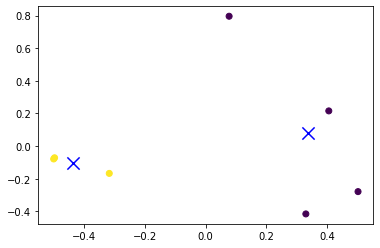

In [22]:
#visualization
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [23]:
#evaluation with labelled dataset
from sklearn.metrics import homogeneity_score
homogeneity_score(df.processed_content, cls.predict(features))

0.3509453429964406

In [24]:

#evaluation with unlabelled dataset
from sklearn.metrics import silhouette_score
silhouette_score(features, labels=cls.predict(features))

0.03278074470371301

In [25]:
#topic modelling
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

random_state = 0

def only_nouns(texts):
    output = []
    for doc in nlp.pipe(texts):
        noun_text = " ".join(token.lemma_ for token in doc if token.pos_ == 'NOUN')
        output.append(noun_text)
    return output


df['noun_content'] = only_nouns(df['content'])

df.head()

,id,topic,heading,summary,date,sub,content,tags,processed_content,noun_content
0,5ef0d321d83b3587cb500efc,"[""football""]","[""VAR not being used correctly: Barcelona coac...","[""Barcelona had a goal ruled out by VAR for of...","[""Updated: Jun 22, 2020 20:03 IST""]","[""Reuters""]","[""The Video Assistant Referee (VAR) system is ...","[""Quique Setien"",""Barcelona""]",video assist refere correct liga barcelona man...,"var system manager win "",""madrid top home side..."
1,5ef0d324d83b3587cb500efd,"[""football""]","[""Mourinho hits back at Mersonâ€™s criticism o...","[""Merson, a pundit with Sky Sports, said 26-ye...","[""Updated: Jun 22, 2020 20:30 IST""]","[""Reuters""]","[""Jose Mourinho launched an impassioned defenc...","[""Jose Mourinho"",""Harry Kane"",""Manchester unit...",jose mourinho launch impass defenc harri kaneâ...,defence form playing style television pundit s...
2,5efff14f86936ae10d2be3c8,"[""football""]","[""Morata double leads Atletico to 3-0 win over...","[""Morata earned a penalty when he was pulled d...","[""Updated: Jul 04, 2020 07:12 IST""]","[""Associated Press""]","[""Alvaro Morata scored twice to lead Atletico ...","[""Alvaro Morata"",""Mallorca"",""Diego Simeone"",""R...",alvaro morata score twice lead atletico madrid...,win finish league team title race leader point...
3,5efff10a86936ae10d2be3aa,"[""cricket""]","[""Sourav Ganguly made Sehwag open, brought in ...","[""Former India opener Wasim Jaffer, who made h...","[""Updated: Jul 04, 2020 08:03 IST""]","[""hindustantimes.com""]","[""Despite not being able to lead India to an I...","[""Sourav Ganguly"",""Wasim Jaffer"",""India"",""Zahe...",despit abl lead india trophi sole india joint ...,trophy winner captain number captain test cric...
4,5ef0d2e5d83b3587cb500edf,"[""cricket""]","[""Jasprit Bumrah is â€˜a different beastâ€™ wh...","[""The man in charge of the team currently is h...","[""Updated: Jun 22, 2020 20:57 IST""]","[""hindustantimes.com""]","[""Mumbai Indians are the most successful team ...","[""Mumbai Indians"",""Jasprit Bumrah"",""Mahela Jay...",mumbai indian success team histori indian prem...,team history team title cliffhanger season vic...


In [27]:
# change this to see different results using the components_ attribute
n_topics = 2

#for extracting features
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer(max_features=5000, stop_words="english", max_df=0.95, min_df=2)
features = vec.fit_transform(df.noun_content)

#for topic modelling

from sklearn.decomposition import NMF
cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=2, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [28]:
# list of unique words found by the vectorizer
feature_names = vec.get_feature_names()

# number of most influencing words to display per topic
n_top_words = 15

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    # topic_vec.argsort() produces a new array
    # in which word_index with the least score is the
    # first array element and word_index with highest
    # score is the last array element. Then using a
    # fancy indexing [-1: -n_top_words-1:-1], we are
    # slicing the array from its end in such a way that
    # top `n_top_words` word_index with highest scores
    # are returned in desceding order
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(feature_names[fid], end=' ')
    print()

0 test captain player people coach team series cricket field head tournament squad president backing job 
1 league goal game match point ball injury striker controversy title referee end play race football 


In [29]:
# to identify topic of a new document
new_articles = [
  '''On papers, India’s 2003 World Cup squad looks equally strong as compared to India’s 2019 World Cup squad. The side led by Sourav Ganguly in 2003 had experienced top-order batsmen such as Virender Sehwag, Sachin Tendulkar, Rahul Dravid, and Ganguly. Virat Kohli’s team in 2019 also had a strong top-order with Shikhar Dhawan, Rohit Sharma and Kohli himself. Ganguly’s pace bowling department looked strong with four top-class seamers in Zaheer Khan, Ashish Nehra, Ajit Agarkar and veteran Javagal Srinath. Kohli had Jasprit Bumrah, Bhuvneshwar Kumar and Mohammed Shami - all at top of their game. Ganguly’s spin department was sorted with veterans Harbhajan Singh and Anil Kumble, while Kohli’s spin bowling options were Yuzvendra Chahal, Kuldeep Yadav and Ravindra Jadeja. ''',
  ''' West Ham twice squandered a lead against Newcastle and had to settle for a 2-2 draw that moved the team four points clear of the Premier League’s relegation zone on Sunday.With five games remaining, West Ham is inching closer to survival but could yet live to regret switching off to allow Jonjo Shelvey to score Newcastle’s second equalizer in the 67th minute — just 92 seconds after Tomas Soucek reclaimed the lead for the visitors.West Ham manager David Moyes threw his hands out in disgust after Shelvey dribbled his way through a gap in the defense and exchanged a one-two with Dwight Gayle before slotting home a low finish.In-form forward Michail Antonio gave West Ham the lead for the first time at St. James’ Park in the fourth minute, only for Miguel Almiron to make it 1-1 in the 17th by sliding in at the near post to turn in a low cross'''
]
# first transform the text into features using vec
# then pass it to transform of cls
# the result will be a matrix of shape [2, 10]
# then we sort the topic id based on the score using argsort
# and take the last one (with the highest score) for each row using `[:,-1]` indexing
cls.transform(vec.transform(new_articles)).argsort(axis=1)[:,-1]

array([0, 1])